In [1]:
!git clone https://github.com/mybothy/bangkit-machine-learning.git

Cloning into 'bangkit-machine-learning'...
remote: Enumerating objects: 3006, done.
remote: Counting objects: 100% (3006/3006), done.
remote: Compressing objects: 100% (3005/3005), done.
remote: Total 3006 (delta 0), reused 3006 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3006/3006), 38.68 MiB | 11.61 MiB/s, done.
Updating files: 100% (3000/3000), done.


In [2]:
%cd bangkit-machine-learning/data

/content/bangkit-machine-learning/data


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
from sklearn.model_selection import train_test_split

print('\u2022 Using TensorFlow Version:', tf.__version__)
print("\u2022 Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.17.1
• Num GPUs Available:  1
• GPU Device Found.


In [4]:
DATA_DIR = f'./'
print(f"There are {len(os.listdir(DATA_DIR))} categories of food.")

There are 3 categories of food.


In [6]:
def train_val_test_ds():
    # Load the entire dataset
    full_ds = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),
        batch_size=32,
        shuffle=True,
        labels='inferred',
        label_mode='int',
        seed=42
    )

    # Get the total size of the dataset
    total_size = int(tf.data.experimental.cardinality(full_ds))

    # Define the sizes for the splits
    train_size = int(total_size * 0.70)
    val_size = int(total_size * 0.20)
    test_size = total_size - train_size - val_size

    # Split the dataset
    test_ds = full_ds.take(test_size)
    val_ds = full_ds.skip(test_size).take(val_size)
    train_ds = full_ds.skip(test_size + val_size)

    return train_ds, val_ds, test_ds

# Load the datasets
train_ds, val_ds, test_ds = train_val_test_ds()

train_ds_size = tf.data.experimental.cardinality(train_ds)
val_ds_size = tf.data.experimental.cardinality(val_ds)
test_ds_size = tf.data.experimental.cardinality(test_ds)

print(f"Train Dataset size: {train_ds_size}")
print(f"Validation Dataset size: {val_ds_size}")
print(f"Test Dataset size: {test_ds_size}")

Found 3000 files belonging to 3 classes.
Train Dataset size: 65
Validation Dataset size: 18
Test Dataset size: 11


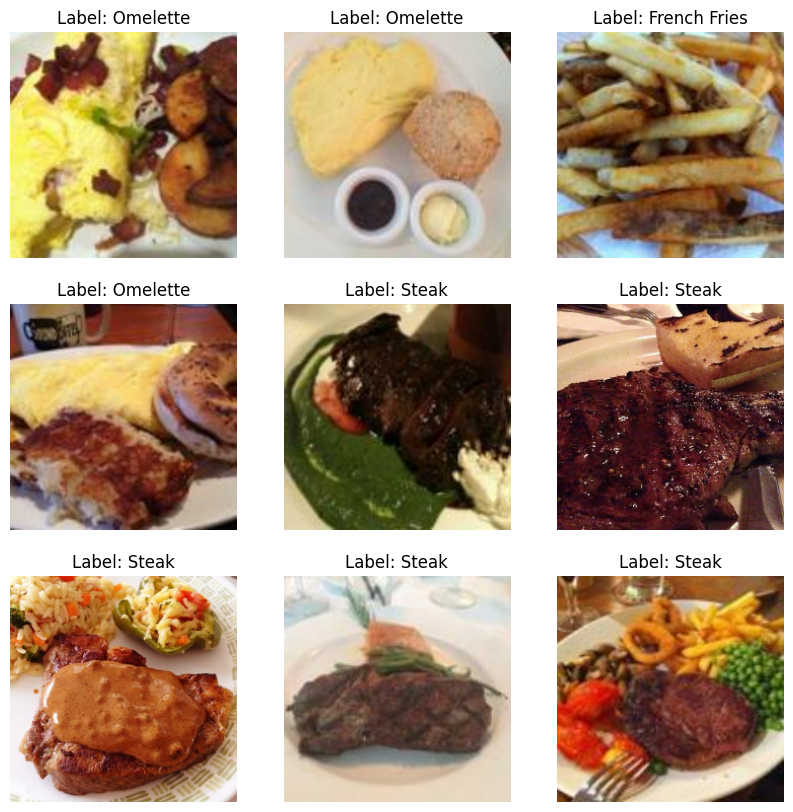

In [7]:
label_names = {
    0: "French Fries",
    1: "Omelette",
    2: "Steak"
}

# Visualize images with label names
for images, labels in val_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_name = label_names[labels[i].numpy()]  # Get the label name
        plt.title(f"Label: {label_name}")
        plt.axis("off")
    plt.show()

In [8]:
#Loading the EfficientNetB0 model for transfer learning
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# fine tuning and add more layers

# Add custom classification head with more layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# Global Average Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add Dense Layers with Batch Normalization and Activation
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout for regularization

x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Final Classification Layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the Model
model = tf.keras.Model(inputs, outputs)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,412,326 (16.83 MB)

 Trainable params: 361,987 (1.38 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

In [10]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',  # Adjust for your task
              metrics=['accuracy'])

In [11]:
# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50  # Adjust based on your needs
    # batch_size=32  # Only needed if datasets are not batched
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4388 - loss: 1.2893 - val_accuracy: 0.8333 - val_loss: 0.6639
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7450 - loss: 0.6133 - val_accuracy: 0.8958 - val_loss: 0.4201
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8332 - loss: 0.4488 - val_accuracy: 0.8958 - val_loss: 0.3358
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8497 - loss: 0.3942 - val_accuracy: 0.9080 - val_loss: 0.2695
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8609 - loss: 0.3468 - val_accuracy: 0.9097 - val_loss: 0.2545
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8725 - loss: 0.3356 - val_accuracy: 0.9271 - val_loss: 0.2078
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8943 - loss: 0.2942 - val_accuracy: 0.9184 - val_loss: 0.2282
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8856 - loss: 0.2850 - val_accuracy: 0.9132 -

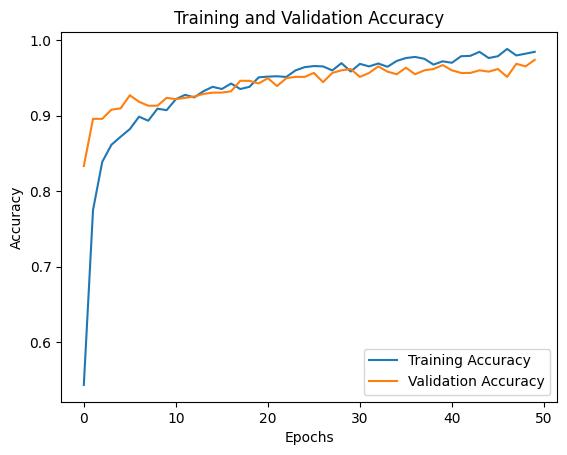

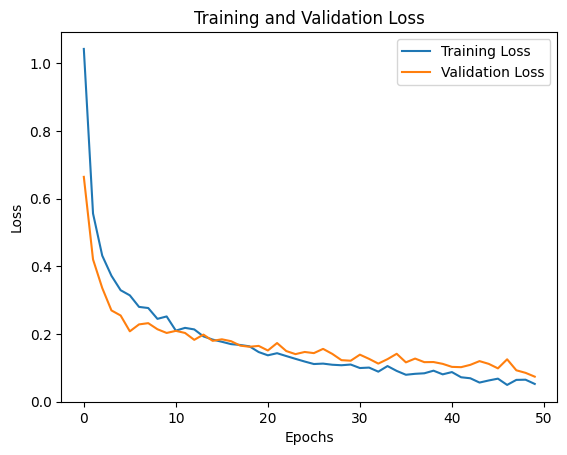

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9503 - loss: 0.1434
Test Loss: 0.1448
Test Accuracy: 0.9489


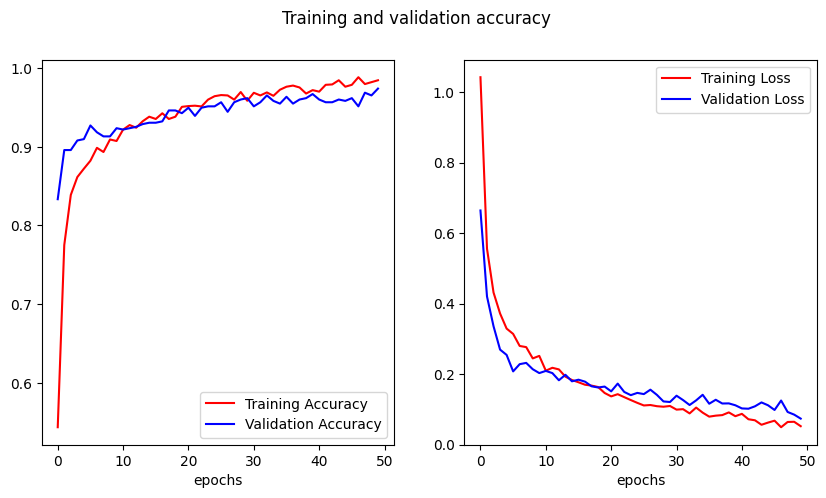

In [14]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


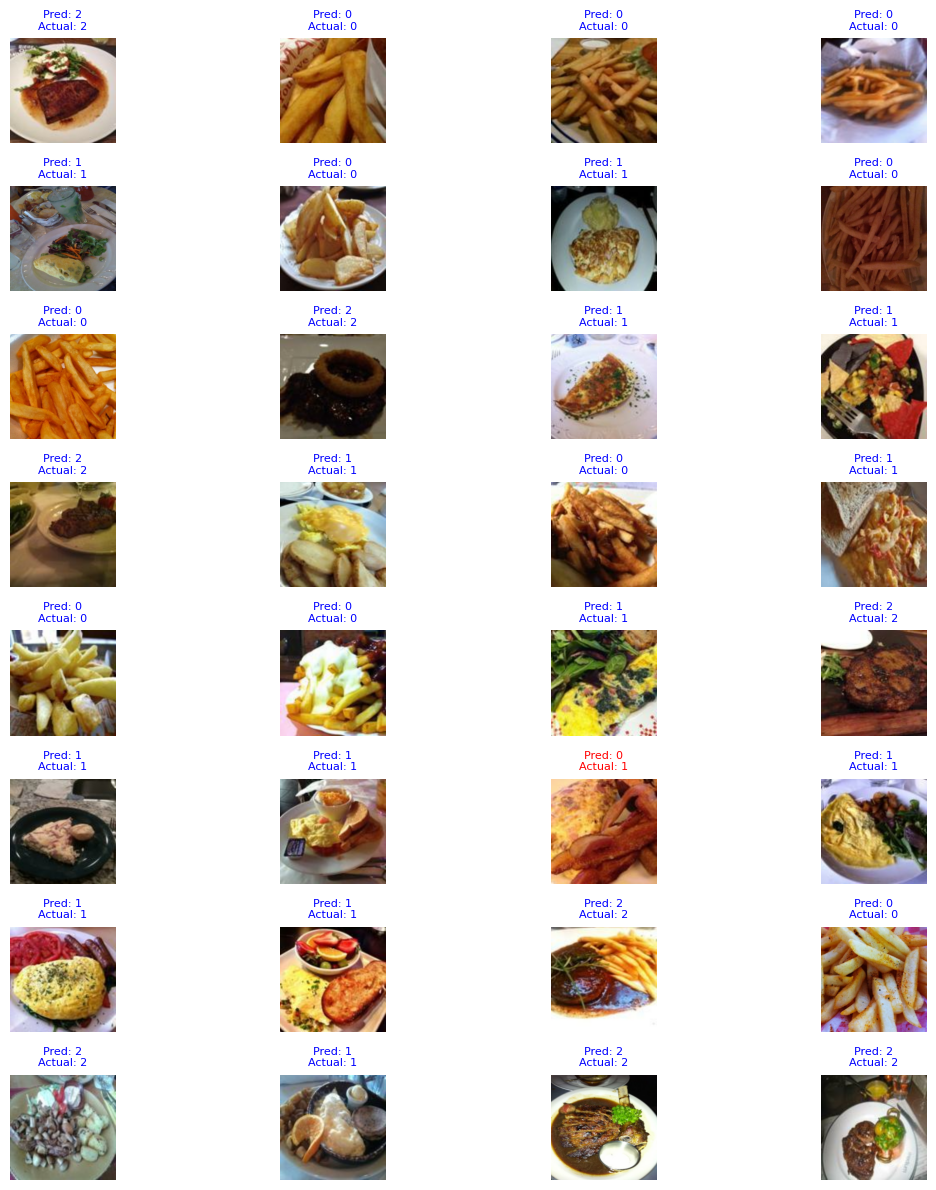

In [15]:
for images, labels in test_ds.take(1):
    # Make predictions on the batch
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate rows and columns for the grid
    num_images = len(images)
    cols = 4  # Set a fixed number of columns
    rows = (num_images + cols - 1) // cols  # Compute the number of rows required

    # Display the images along with predictions and actual labels
    plt.figure(figsize=(12, 12))  # Adjust figure size as needed

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)  # Adjust grid based on batch size
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert image tensor to uint8 for visualization
        plt.axis('off')  # Remove axis lines for clarity

        # Display predicted and actual labels as the title
        plt.title(f"Pred: {predicted_classes[i]}\nActual: {labels[i].numpy()}",
                  fontsize=8, color='blue' if predicted_classes[i] == labels[i].numpy() else 'red')

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

In [16]:
# Save the model in HDF5 format
model.save('my_model.h5')  # 'my_model.h5' is the filename where the model will be saved


In [17]:
import keras

keras.saving.save_model(model, 'my_model.keras')


In [18]:
import tensorflow as tf
import ipywidgets as widgets
from io import BytesIO
import numpy as np
from IPython.display import display

# Create the widget for file upload
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

# Preprocessing function to scale the image for EfficientNetB0
def preprocess_image(image):
    """ Function to preprocess the image for EfficientNetB0 input. """
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    # Load and preprocess the image
    image = tf.keras.utils.load_img(file, target_size=(224, 224))  # EfficientNetB0 expects (224, 224)
    image = tf.keras.utils.img_to_array(image)
    image = preprocess_image(image)  # EfficientNetB0 requires specific preprocessing
    image = np.expand_dims(image, axis=0)

    # Predict the class using the model
    prediction = model.predict(image, verbose=0)

    # Assuming the output layer has 3 classes (e.g., human, horse, other), apply softmax
    predicted_class = np.argmax(prediction)  # For multi-class classification

    with out:
        # Map prediction to class names
        class_names = ["French Fries", "Omelette", "Steak"]  # Modify based on your label names
        print(f"{filename} is predicted to be: {class_names[predicted_class]}")

def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    for name, data in change.new.items():  # Iterate through dictionary
        file_jpgdata = BytesIO(data['content'])  # Access 'content' from the dictionary
        file_predict(name, file_jpgdata, out)

# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

In [ ]:
import tensorflow as tf
import ipywidgets as widgets
from io import BytesIO
import numpy as np
from IPython.display import display

# Create the widget for file upload
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

# Preprocessing function to scale the image for EfficientNetB0
def preprocess_image(image):
    """ Function to preprocess the image for EfficientNetB0 input. """
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    # Load and preprocess the image
    image = tf.keras.utils.load_img(file, target_size=(224, 224))  # EfficientNetB0 expects (224, 224)
    image = tf.keras.utils.img_to_array(image)
    image = preprocess_image(image)  # EfficientNetB0 requires specific preprocessing
    image = np.expand_dims(image, axis=0)

    # Predict the class using the model
    prediction = model.predict(image, verbose=0)

    # Assuming the output layer has 3 classes (e.g., human, horse, other), apply softmax
    predicted_class = np.argmax(prediction)  # For multi-class classification

    # Map prediction to class names and nutritional data
    class_names = ["French Fries", "Omelette", "Steak"]  # Modify based on your label names
    nutrition_data = {
        "French Fries": {
            "Calories": "312 kcal",
            "Carbohydrates": "41g",
            "Protein": "3.4g",
            "Fat": "15g",
            "Fiber": "3g"
        },
        "Omelette": {
            "Calories": "154 kcal",
            "Carbohydrates": "0.6g",
            "Protein": "11g",
            "Fat": "11g",
            "Cholesterol": "372mg"
        },
        "Steak": {
            "Calories": "271 kcal",
            "Carbohydrates": "0g",
            "Protein": "25g",
            "Fat": "18g",
            "Iron": "2.6mg"
        }
    }

    predicted_label = class_names[predicted_class]
    nutrition = nutrition_data[predicted_label]

    with out:
        # Print prediction and nutritional data
        print(f"{filename} is predicted to be: {predicted_label}")
        print("Nutritional Information:")
        for key, value in nutrition.items():
            print(f"  {key}: {value}")
        print("\n")

def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    for name, data in change.new.items():  # Iterate through dictionary
        file_jpgdata = BytesIO(data['content'])  # Access 'content' from the dictionary
        file_predict(name, file_jpgdata, out)

# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names='value')


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

In [20]:
import tensorflow as tf
from keras.models import load_model

model = load_model("my_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# converter.optimizations = [tf.lite.Optimize.DEFAULT]

lite_model = converter.convert()

with open("lite_my_model.tflite","wb") as f:
    f.write(lite_model)

Saved artifact at '/tmp/tmparxcblqk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139030439533504: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139030439534560: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139030439540544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439536320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439536496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439539840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439560640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439537904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439562400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030439560816: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [21]:
# Load the model
model = load_model("my_model.h5")

# Compile the model with the same settings as during training
model.compile(
    optimizer="adam",  # Replace with your actual optimizer
    loss="sparse_categorical_crossentropy",  # Replace with your actual loss function
    metrics=["accuracy"]  # Replace with your actual metrics
)


In [22]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

lite_model = converter.convert()

# Save the TFLite model
with open("lite_my_model_compile.tflite", "wb") as f:
    f.write(lite_model)


Saved artifact at '/tmp/tmphd5ciysj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139030137809808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139030137810864: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139030137811392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137539744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137536928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137538512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137539040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137544672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137544320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139030137546080: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [23]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
!ls "/content/drive/My Drive/tes"


french_fries  omelette	steak


In [25]:
import tensorflow as tf
from keras.models import load_model

# Load a pre-trained model
model = load_model("my_model.h5")

# Compile the model (optional if already compiled)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Prepare the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/drive/My Drive/tes",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode="int"
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

# Display the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Found 17 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 1.0000 - loss: 0.1101
Test Loss: 0.1101
Test Accuracy: 1.0000


Class names: ['french_fries', 'omelette', 'steak']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


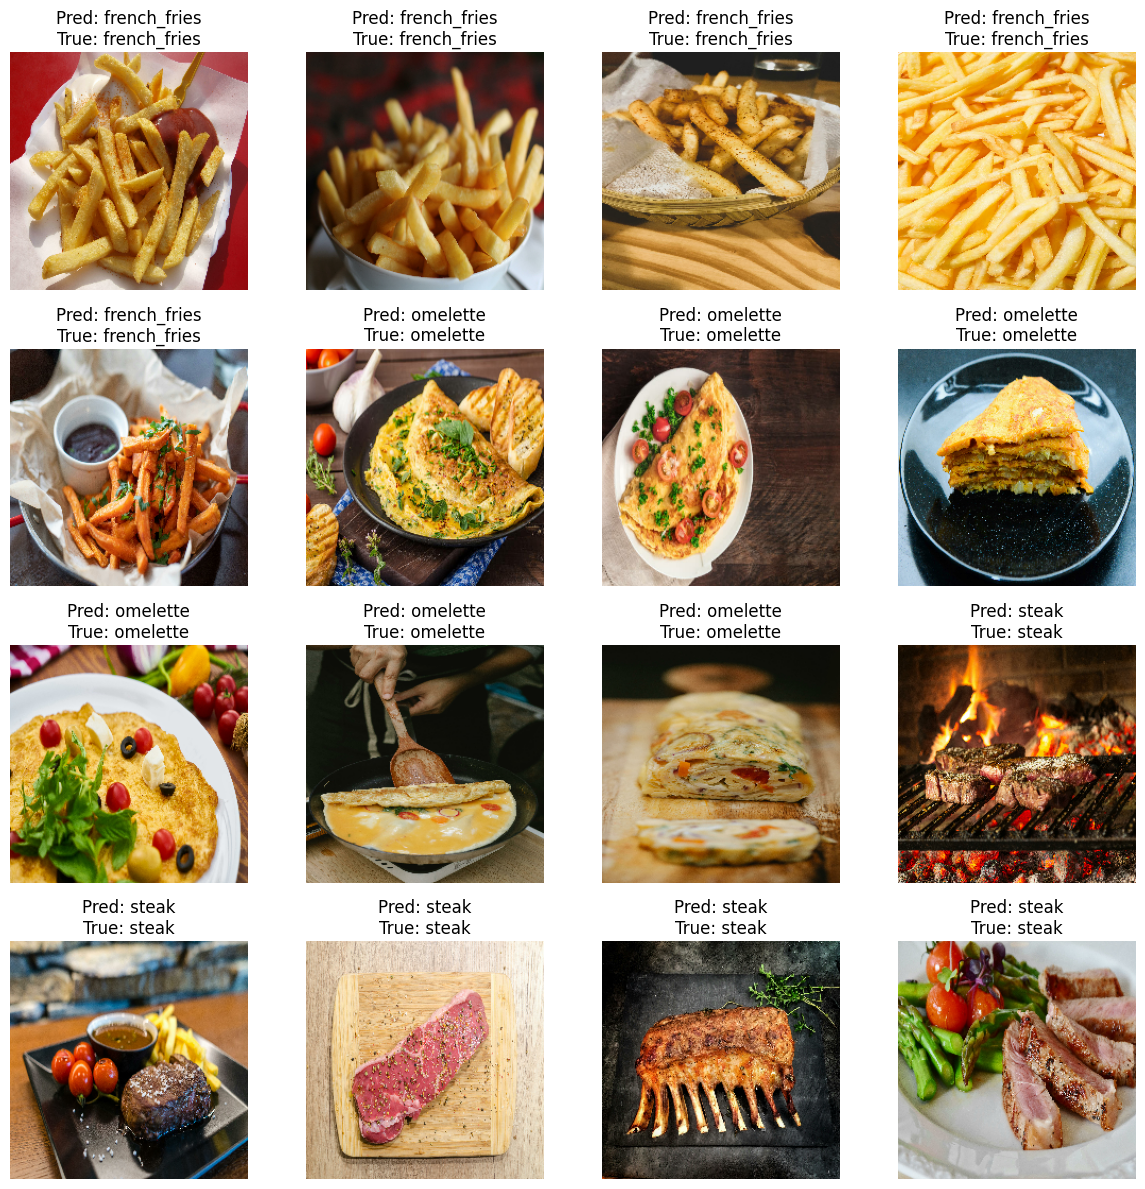

In [28]:
# Get class names (if available from directory)
class_names = test_ds.class_names
print("Class names:", class_names)

# Loop through the test dataset to predict and display images
for images, labels in test_ds.take(1):  # Take 1 batch from the test dataset
    predictions = model.predict(images)  # Predict on the batch
    predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

    # Create a 4x4 grid for plotting images
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Create a 4x4 grid of subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    # Plot images in the 4x4 grid
    for i in range(16):  # 16 images in total (4x4 grid)
        axes[i].imshow(images[i].numpy().astype("uint8"))  # Show the image
        axes[i].set_title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[labels[i]]}")
        axes[i].axis('off')  # Remove axis for a cleaner look

    # Show the plot
    plt.tight_layout()
    plt.show()

In [29]:
from google.colab import files

# Download the saved model
files.download("my_model.h5")
files.download("my_model.keras")
files.download("lite_my_model.tflite")
files.download("lite_my_model_compile.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>